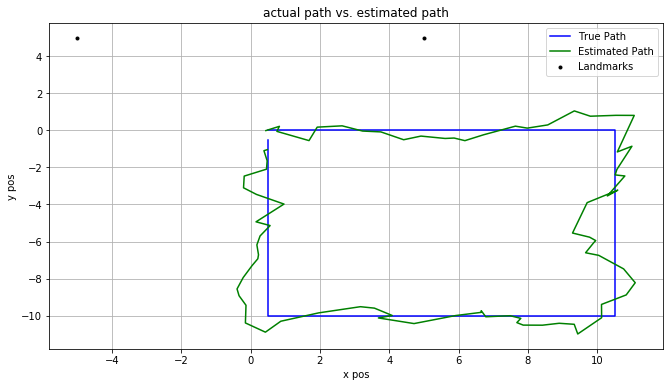

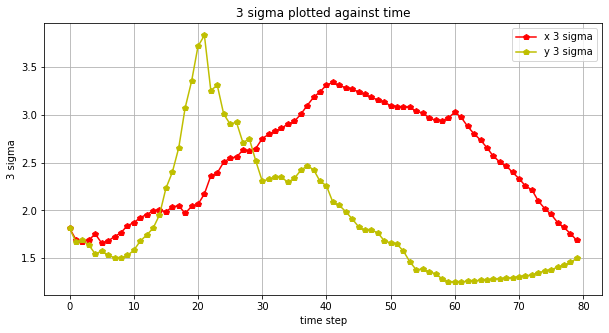

In [ ]:
# prob 1
import numpy as np
import matplotlib.pyplot as plt

# landmarks
landmarks = np.array([[5, 5], [-5, 5]])

# noise covariance
R = 0.1 * np.eye(4)
# measurement noise covariance
Q = 0.5 * np.eye(2)
delta_t = 0.5
timesteps = 80
v_commands = [(1, 0)] * 20 + [(0, -1)] * 20 + [(-1, 0)] * 20 + [(0, 1)] * 20  

# initial state
x_est = np.array([0, 0, 0, 0])  # [px, py, vx, vy]
# initial covariance
P_est = np.eye(4)
# beleifs throughout time
beliefs = []
# covariances throughout time
covariances = []
#actual initial position
x_true = np.array([0, 0, 1, 0])  # [px, py, vx, vy]
# actual positions throughout time
true_positions = []

# measurement model
def measurement_model(x, landmark):
    px, py, _, _ = x
    lx, ly = landmark
    return np.sqrt((px - lx)**2 + (py - ly)**2)

# jacobian for measurement model
def H_jacobian(x, landmark):
    px, py, _, _ = x
    lx, ly = landmark
    dist = np.sqrt((px - lx)**2 + (py - ly)**2)
    return np.array([(px - lx) / dist, (py - ly) / dist, 0, 0])

# prop model
def state_transition(x, v):
    px, py, vx, vy = x
    return np.array([px + vx * delta_t, py + vy * delta_t, v[0], v[1]])

#jacobian for prop model
F = np.array([[1, 0, delta_t, 0],
              [0, 1, 0, delta_t],
              [0, 0, 1, 0],
              [0, 0, 0, 1]])

for t in range(timesteps):
    v_true = v_commands[t] #v_true is the vx vy commands
    x_true = state_transition(x_true, v_true) #specifies the updated state
    true_positions.append(x_true[:2]) #collects just x, y of updated state
    
    # predict
    x_pred = state_transition(x_est, v_commands[t])
    P_pred = F @ P_est @ F.T + R
    # update measurement
    z = np.array([measurement_model(x_true, landmarks[0]) + np.random.normal(0, Q[0, 0]),
                  measurement_model(x_true, landmarks[1]) + np.random.normal(0, Q[1, 1])])
    # predicted measurement
    z_pred = np.array([measurement_model(x_pred, landmarks[0]),
                       measurement_model(x_pred, landmarks[1])])

    # jacobians
    H1 = H_jacobian(x_pred, landmarks[0])
    H2 = H_jacobian(x_pred, landmarks[1])
    H = np.vstack((H1, H2))
    S = H @ P_pred @ H.T + Q
    K = P_pred @ H.T @ np.linalg.inv(S)

    y = z - z_pred
    # update state
    x_est = x_pred + K @ y
    P_est = (np.eye(4) - K @ H) @ P_pred
    beliefs.append(x_est[:2])
    covariances.append(P_est)


beliefs = np.array(beliefs)
true_positions = np.array(true_positions)
sigma_bounds = np.sqrt(np.array([np.diag(P) for P in covariances]))[:, :2] * 3

plt.figure(figsize=(11, 6))  # Adjusted figure size
plt.scatter(landmarks[:, 0], landmarks[:, 1], c='black', marker='.', label='Landmarks')
plt.plot(true_positions[:, 0], true_positions[:, 1], 'b-', label='True Path')
plt.plot(beliefs[:, 0], beliefs[:, 1], 'g-', label='Estimated Path')

plt.xlabel('x pos')
plt.ylabel('y pos')
plt.title('actual path vs. estimated path')
plt.legend()
plt.grid(True)
plt.figure(figsize=(10, 5))  # Adjusted figure size
plt.plot(range(timesteps), sigma_bounds[:, 0], 'rp-', label='x 3 sigma')
plt.plot(range(timesteps), sigma_bounds[:, 1], 'yp-', label='y 3 sigma')

plt.xlabel('time step')
plt.ylabel('3 sigma')
plt.title('3 sigma plotted against time')
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
# prob 3 part c
# pose in SE(2)
class Pose:
    def __init__(self, x, y, theta):
        self.x = x
        self.y = y
        # in radians
        self.theta = theta

    def to_matrix(self):
        return np.array([
            [np.cos(self.theta), -np.sin(self.theta), self.x],
            [np.sin(self.theta), np.cos(self.theta), self.y],
            [0, 0, 1] ])

#adds gaussian noise to wheel speeds (I think)
def add_noise(commanded_speed, sigma):
    noise = np.random.normal(0, sigma)
    return commanded_speed + noise

# particles is the belief of the position of the robot at time step t1
# ws_l is the wheel speed of the left wheel
# ws_r is the wheel speed of the right wheel
# t1 is the current time step
# t2 is the next timestep
# r is the wheel radius
# w is the track width
# s_l is the standard deviation of noise for left wheel speed
# s_r is the standard deviation of noise for the right whell speed
def particle_filter_propagate(particles, ws_l, ws_r, t1, t2, r, w, s_l, s_r):
    # change in time
    dt = t2 - t1
    # set of particles that will be returned for time step 2 (t2)
    new_particles = []

    for particle in particles:
        # the wheel speed may have some noise
        ns_l = add_noise(ws_l, s_l)
        ns_r = add_noise(ws_r, s_r)

        # velocities (linear and angular)
        v = r * (ns_l + ns_r) / 2.0
        omega = r * (ns_r - ns_l) / w

        # calcualate change in theta, x pos, and y pos (pose)
        delta_theta = omega * dt
        delta_x = v / omega * (np.sin(particle[2, 0] + delta_theta) - np.sin(particle[2, 0]))
        delta_y = -v / omega * (np.cos(particle[2, 0] + delta_theta) - np.cos(particle[2, 0]))

        # 3x3 SE(2) transformation matrix that represents the change in pose
        delta_T = np.array([
            [np.cos(delta_theta), -np.sin(delta_theta), delta_x],
            [np.sin(delta_theta), np.cos(delta_theta), delta_y],
            [0, 0, 1]
        ])

        # update for the particle pose in SE(2) form
        new_particle_matrix = particle @ delta_T
        new_particles.append(new_particle_matrix)

    return new_particles

In [ ]:
# prob 3 part d

#particles is the list of particles at time step t
# measurement is the sampled measurement
# noise_dev is the noise standard deviation
def particle_filter_update(particles, measurement, noise_dev):
    num_p = len(particles)
    # initialize zeros for weights
    weights = np.zeros(num_p)

    # importance weights
    for i in range(num_p):
        # transforms the measurement from the global coordinate frame to the loca coordinate frame of the particle we are currently at
        local_measurement = np.linalg.inv(particles[i]) @ np.array([measurement[0], measurement[1], 1])

        # the squared distance between the transformed measurement and the particles position
        distance_squared = np.linalg.norm(local_measurement[:2] - np.array([0, 0]))**2

        # based on the sqaured distance adn the standard deviation of noise, if the distance is smaller, the likelihood is higher
        log_weights = -distance_squared / (2 * noise_dev**2)
        
        weight = np.exp(-distance_squared / (2 * noise_dev**2))
        weights[i] = weight 

    # we can normalize the log weights here
    log_weights -= np.max(log_weights)
    weights_sum = np.sum(weights)
#     if weights_sum > 0:
#         weights = weights / weights_sum
#     else:
    weights = np.ones(num_particles) / num_particles 

    # here is our new set of particles
    new_particles = []
    rand = np.random.uniform(0, 1/num_p)
    # weight variable
    c = weights[0]
    # index for tracking the current particle
    i = 0

    #loop through the particles 
    for j in range(num_p):
        # this will filter out particles with lower weights over time
        thresh = rand + j/num_p
        while thresh > c:
            i += 1
            c += weights[i]
        new_particles.append(particles[i])

    return new_particles

mean:  [1.06966025 3.07622746]
covariance:  [[0.40162035 0.04139016]
 [0.04139016 0.02052886]]


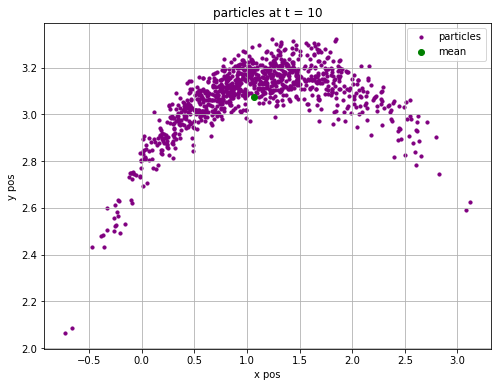

In [ ]:
# part 3e
# left speed
s_l = 1.5
# right speed
s_r = 2.0
# radius
r = 0.25
# distacne between wheels
w = 0.5
# left wheel noise
l_n = 0.05
#right wheel noise
r_n = 0.05

init_pos = Pose(0, 0, 0).to_matrix() 

N = 1000

t1 = 0.0
t2 = 10.0

particles = [init_pos for _ in range(N)]

# call function
new_particles = particle_filter_propagate(particles, s_l, s_r, t1, t2, r, w, r_n, r_n)

positions = np.array([(pose[0, 2], pose[1, 2]) for pose in new_particles])
orientations = np.array([pose[0, 0] for pose in new_particles])  # Extract cos(theta)


#mean and covariance
mean_position = np.mean(positions, axis=0)
covariance_position = np.cov(positions, rowvar=False)

print("mean: ", mean_position)
print("covariance: ", covariance_position)

plt.figure(figsize=(8, 6))
plt.scatter(positions[:, 0], positions[:, 1], s=10, c='purple', label='particles')
plt.scatter(mean_position[0], mean_position[1], c='green', marker='o', label='mean')
plt.xlabel('x pos')
plt.ylabel('y pos')
plt.title('particles at t = 10')
plt.legend()
plt.grid(True)

plt.show()

time t
mena pos: [1.65349512 1.18688249]
covariance pos:
 [[ 0.01937395 -0.01571845]
 [-0.01571845  0.01600456]]
time t
mena pos: [-0.89449746  3.1074637 ]
covariance pos:
 [[0.27747444 0.21827865]
 [0.21827865 0.45460689]]
time t
mena pos: [1.41732033 1.1629164 ]
covariance pos:
 [[0.51091184 0.04236759]
 [0.04236759 1.12701977]]
time t
mena pos: [-0.14736243  0.52145274]
covariance pos:
 [[ 2.0123894  -0.24608176]
 [-0.24608176  0.94573951]]


<Figure size 720x576 with 0 Axes>

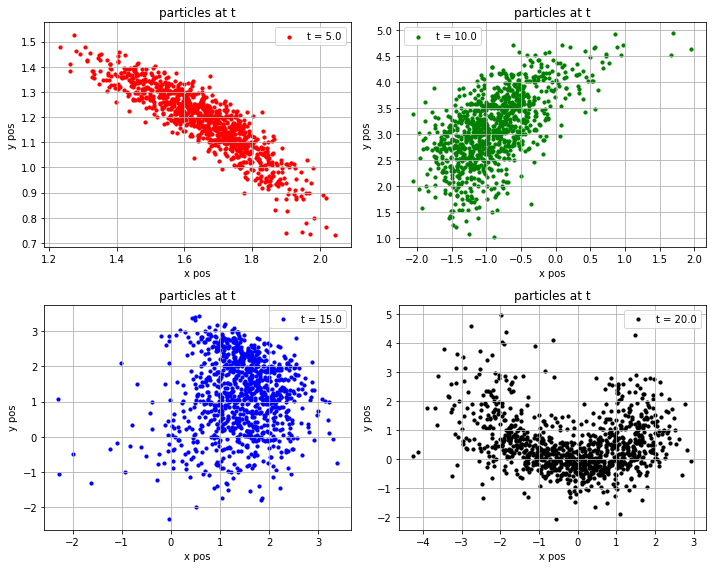

In [ ]:
#part 3f
s_l = 1.5
s_r = 2.0
r = 0.25
w = 0.5
l_n = 0.05
r_n = 0.05

initial_pose = Pose(0, 0, 0).to_matrix()

num_particles = 1000

times = [5.0, 10.0, 15.0, 20.0]

# particle set initialization
particles = [initial_pose for _ in range(num_particles)]

colors = ['red', 'green', 'blue', 'black']

plt.figure(figsize=(10, 8))

fig, axes = plt.subplots(2, 2, figsize=(10, 8))  # 2x2 grid of plots
axes = axes.flatten()  # Flatten the axes array for easier indexing

for i, t in enumerate(times):
    # Propagate particles
    particles = particle_filter_propagate(particles, s_l, s_r, 0, t, r, w, l_n, r_n)

    # Extract positions
    positions = np.array([(pose[0, 2], pose[1, 2]) for pose in particles])

    # Calculate empirical mean and covariance
    mean_pos = np.mean(positions, axis=0)
    covariance = np.cov(positions, rowvar=False)

    # Print mean and covariance
    print(f"time t")
    print("mena pos:", mean_pos)
    print("covariance pos:\n", covariance)

    # Plot particles on the corresponding subplot
    axes[i].scatter(positions[:, 0], positions[:, 1], s=10, c=colors[i], label=f't = {t}')
    axes[i].set_xlabel('x pos')
    axes[i].set_ylabel('y pos')
    axes[i].set_title(f'particles at t')
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

time t
mena pos: [1.65349512 1.18688249]
covariance pos:
 [[ 0.01937395 -0.01571845]
 [-0.01571845  0.01600456]]
time t
mena pos: [-0.89449746  3.1074637 ]
covariance pos:
 [[0.27747444 0.21827865]
 [0.21827865 0.45460689]]
time t
mena pos: [1.41732033 1.1629164 ]
covariance pos:
 [[0.51091184 0.04236759]
 [0.04236759 1.12701977]]
time t
mena pos: [-0.14736243  0.52145274]
covariance pos:
 [[ 2.0123894  -0.24608176]
 [-0.24608176  0.94573951]]


<Figure size 720x576 with 0 Axes>

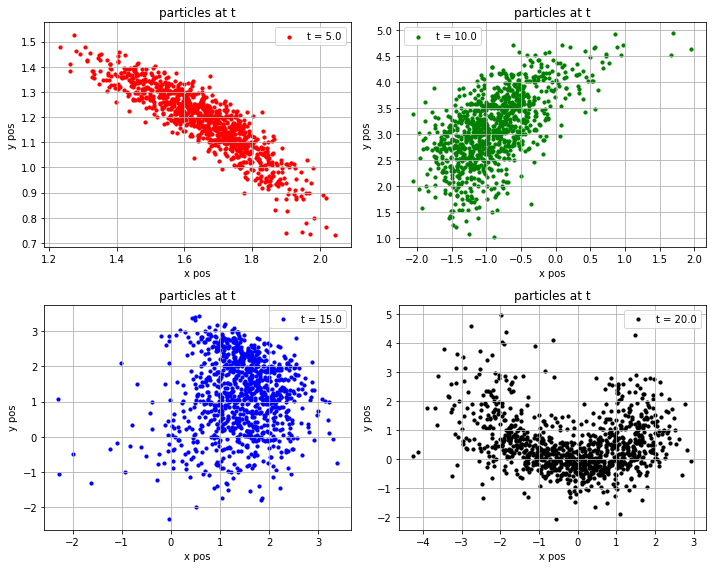

In [ ]:
#part 3f
s_l = 1.5
s_r = 2.0
r = 0.25
w = 0.5
l_n = 0.05
r_n = 0.05

initial_pose = Pose(0, 0, 0).to_matrix()

num_particles = 1000

times = [5.0, 10.0, 15.0, 20.0]

# particle set initialization
particles = [initial_pose for _ in range(num_particles)]

colors = ['red', 'green', 'blue', 'black']

plt.figure(figsize=(10, 8))

fig, axes = plt.subplots(2, 2, figsize=(10, 8))  # 2x2 grid of plots
axes = axes.flatten()  # Flatten the axes array for easier indexing

for i, t in enumerate(times):
    # Propagate particles
    particles = particle_filter_propagate(particles, s_l, s_r, 0, t, r, w, l_n, r_n)

    # Extract positions
    positions = np.array([(pose[0, 2], pose[1, 2]) for pose in particles])

    # Calculate empirical mean and covariance
    mean_pos = np.mean(positions, axis=0)
    covariance = np.cov(positions, rowvar=False)

    # Print mean and covariance
    print(f"time t")
    print("mena pos:", mean_pos)
    print("covariance pos:\n", covariance)

    # Plot particles on the corresponding subplot
    axes[i].scatter(positions[:, 0], positions[:, 1], s=10, c=colors[i], label=f't = {t}')
    axes[i].set_xlabel('x pos')
    axes[i].set_ylabel('y pos')
    axes[i].set_title(f'particles at t')
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

time t
mena pos: [1.65349512 1.18688249]
covariance pos:
 [[ 0.01937395 -0.01571845]
 [-0.01571845  0.01600456]]
time t
mena pos: [-0.89449746  3.1074637 ]
covariance pos:
 [[0.27747444 0.21827865]
 [0.21827865 0.45460689]]
time t
mena pos: [1.41732033 1.1629164 ]
covariance pos:
 [[0.51091184 0.04236759]
 [0.04236759 1.12701977]]
time t
mena pos: [-0.14736243  0.52145274]
covariance pos:
 [[ 2.0123894  -0.24608176]
 [-0.24608176  0.94573951]]


<Figure size 720x576 with 0 Axes>

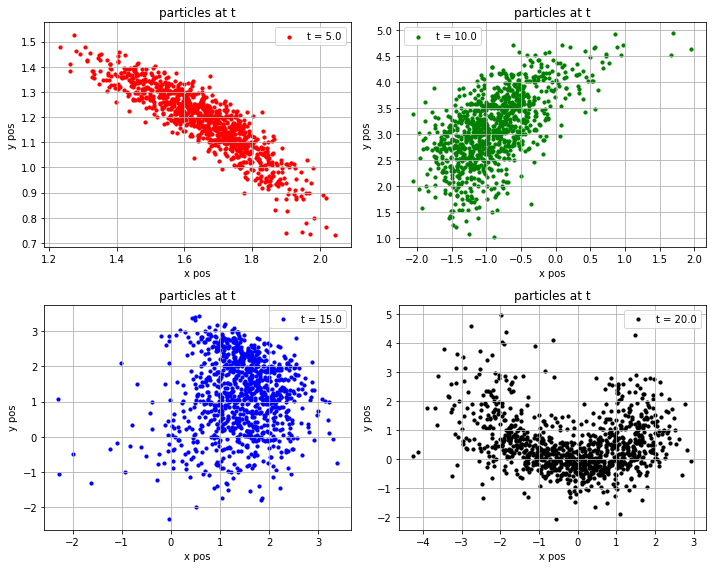

In [ ]:
#part 3f
s_l = 1.5
s_r = 2.0
r = 0.25
w = 0.5
l_n = 0.05
r_n = 0.05

initial_pose = Pose(0, 0, 0).to_matrix()

num_particles = 1000

times = [5.0, 10.0, 15.0, 20.0]

# particle set initialization
particles = [initial_pose for _ in range(num_particles)]

colors = ['red', 'green', 'blue', 'black']

plt.figure(figsize=(10, 8))

fig, axes = plt.subplots(2, 2, figsize=(10, 8))  # 2x2 grid of plots
axes = axes.flatten()  # Flatten the axes array for easier indexing

for i, t in enumerate(times):
    # Propagate particles
    particles = particle_filter_propagate(particles, s_l, s_r, 0, t, r, w, l_n, r_n)

    # Extract positions
    positions = np.array([(pose[0, 2], pose[1, 2]) for pose in particles])

    # Calculate empirical mean and covariance
    mean_pos = np.mean(positions, axis=0)
    covariance = np.cov(positions, rowvar=False)

    # Print mean and covariance
    print(f"time t")
    print("mena pos:", mean_pos)
    print("covariance pos:\n", covariance)

    # Plot particles on the corresponding subplot
    axes[i].scatter(positions[:, 0], positions[:, 1], s=10, c=colors[i], label=f't = {t}')
    axes[i].set_xlabel('x pos')
    axes[i].set_ylabel('y pos')
    axes[i].set_title(f'particles at t')
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

time t
mena pos: [1.65349512 1.18688249]
covariance pos:
 [[ 0.01937395 -0.01571845]
 [-0.01571845  0.01600456]]
time t
mena pos: [-0.89449746  3.1074637 ]
covariance pos:
 [[0.27747444 0.21827865]
 [0.21827865 0.45460689]]
time t
mena pos: [1.41732033 1.1629164 ]
covariance pos:
 [[0.51091184 0.04236759]
 [0.04236759 1.12701977]]
time t
mena pos: [-0.14736243  0.52145274]
covariance pos:
 [[ 2.0123894  -0.24608176]
 [-0.24608176  0.94573951]]


<Figure size 720x576 with 0 Axes>

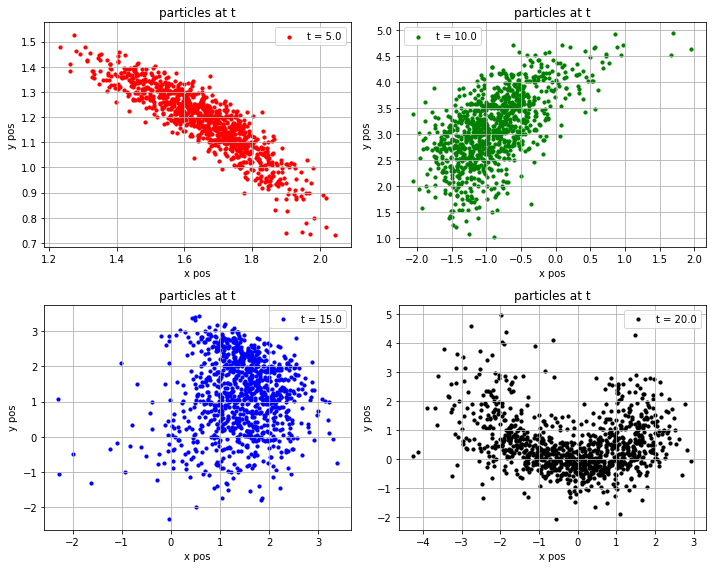

In [ ]:
#part 3f
s_l = 1.5
s_r = 2.0
r = 0.25
w = 0.5
l_n = 0.05
r_n = 0.05

initial_pose = Pose(0, 0, 0).to_matrix()

num_particles = 1000

times = [5.0, 10.0, 15.0, 20.0]

# particle set initialization
particles = [initial_pose for _ in range(num_particles)]

colors = ['red', 'green', 'blue', 'black']

plt.figure(figsize=(10, 8))

fig, axes = plt.subplots(2, 2, figsize=(10, 8))  # 2x2 grid of plots
axes = axes.flatten()  # Flatten the axes array for easier indexing

for i, t in enumerate(times):
    # Propagate particles
    particles = particle_filter_propagate(particles, s_l, s_r, 0, t, r, w, l_n, r_n)

    # Extract positions
    positions = np.array([(pose[0, 2], pose[1, 2]) for pose in particles])

    # Calculate empirical mean and covariance
    mean_pos = np.mean(positions, axis=0)
    covariance = np.cov(positions, rowvar=False)

    # Print mean and covariance
    print(f"time t")
    print("mena pos:", mean_pos)
    print("covariance pos:\n", covariance)

    # Plot particles on the corresponding subplot
    axes[i].scatter(positions[:, 0], positions[:, 1], s=10, c=colors[i], label=f't = {t}')
    axes[i].set_xlabel('x pos')
    axes[i].set_ylabel('y pos')
    axes[i].set_title(f'particles at t')
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

errors between time steps:
  5.0 to 10.0: 10.2223
  10.0 to 15.0: 8.6603
  15.0 to 20.0: 2.5274


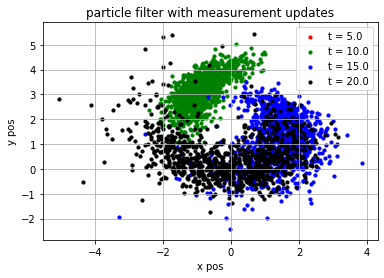

In [ ]:
l_s = 1.5
r_s = 2.0
r = 0.25
w = 0.5
l_n = 0.05
r_n = 0.05
n = 0.10

initial_pose = Pose(0, 0, 0).to_matrix()

num_particles = 1000

particles = [initial_pose for _ in range(num_particles)]

times = [5.0, 10.0, 15.0, 20.0]
measurements = np.array([
    [1.6561, 1.2847],
    [1.0505, 3.1059],
    [-0.9875, 3.2118],
    [-1.6450, 1.1978]
])

average_positions = []

for i, t in enumerate(times):
    # propagate
    particles = particle_filter_propagate(particles, l_s, r_s, 0, t, r, w, l_n, r_n)

    # update particle weights
    measurement = measurements[i]
    particles = particle_filter_update(particles, measurement, n)

    # get x and y positions of the particles
    positions = np.array([(pose[0, 2], pose[1, 2]) for pose in particles])

    # average position calcualation
    mean_pos = np.mean(positions, axis=0)
    average_positions.append(mean_pos)
    plt.scatter(positions[:, 0], positions[:, 1], s=10, c=colors[i], label=f't = {t}')

average_positions = np.array(average_positions)

squared_errors = np.sum(np.diff(average_positions, axis=0)**2, axis=1)

# print out errors
print("errors between time steps:")
for i, error in enumerate(squared_errors):
    print(f"  {times[i]} to {times[i+1]}: {error:.4f}")
    
plt.xlabel('x pos')
plt.ylabel('y pos')
plt.title('particle filter with measurement updates')
plt.legend()
plt.grid(True)
plt.show()